In [1]:
# Library imports
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn import metrics
import math
import timm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils

from data import prepare_train_test_images, ArcFaceDataset

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Looking at the images

In [2]:
# define root path of te working directory.
ROOT_PATH = os.path.abspath(os.getcwd())[:-4]

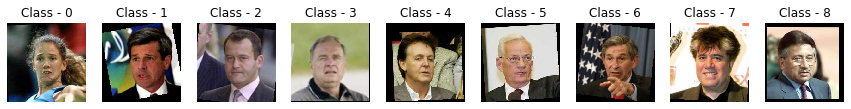

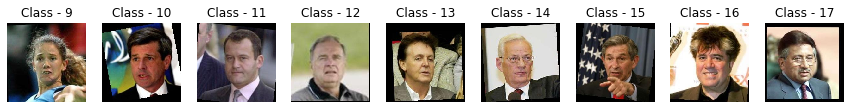

In [3]:
img1 = Image.open(os.path.join(ROOT_PATH, "arcFace_dataset", "Patty_Schnyder", "Patty_Schnyder_0001.jpg"))
img2 = Image.open(os.path.join(ROOT_PATH, "arcFace_dataset", 'Paul_Bremer', 'Paul_Bremer_0001.jpg'))
img3 = Image.open(os.path.join(ROOT_PATH, "arcFace_dataset", 'Paul_Burrell', 'Paul_Burrell_0001.jpg'))
img4 = Image.open(os.path.join(ROOT_PATH, "arcFace_dataset", 'Paul_Martin', 'Paul_Martin_0001.jpg'))
img5 = Image.open(os.path.join(ROOT_PATH, "arcFace_dataset", 'Paul_McCartney', 'Paul_McCartney_0001.jpg'))
img6 = Image.open(os.path.join(ROOT_PATH, "arcFace_dataset", 'Paul_ONeill', 'Paul_ONeill_0001.jpg'))
img7 = Image.open(os.path.join(ROOT_PATH, "arcFace_dataset", 'Paul_Wolfowitz', 'Paul_Wolfowitz_0001.jpg'))
img8 = Image.open(os.path.join(ROOT_PATH, "arcFace_dataset", 'Pedro_Almodovar', 'Pedro_Almodovar_0001.jpg'))
img9 = Image.open(os.path.join(ROOT_PATH, "arcFace_dataset", "Pervez_Musharraf", "Pervez_Musharraf_0001.jpg"))
img10 = Image.open(os.path.join(ROOT_PATH, "arcFace_dataset", 'Pete_Sampras', 'Pete_Sampras_0001.jpg'))
img11 = Image.open(os.path.join(ROOT_PATH, "arcFace_dataset", 'Peter_Struck', 'Peter_Struck_0001.jpg'))
img12 = Image.open(os.path.join(ROOT_PATH, "arcFace_dataset", 'Pierce_Brosnan', 'Pierce_Brosnan_0001.jpg'))
img13 = Image.open(os.path.join(ROOT_PATH, "arcFace_dataset", 'Queen_Elizabeth_II', 'Queen_Elizabeth_II_0001.jpg'))
img14 = Image.open(os.path.join(ROOT_PATH, "arcFace_dataset", 'Rachel_Hunter', 'Rachel_Hunter_0001.jpg'))
img15 = Image.open(os.path.join(ROOT_PATH, "arcFace_dataset", 'Ralf_Schumacher', 'Ralf_Schumacher_0001.jpg'))
img16 = Image.open(os.path.join(ROOT_PATH, "arcFace_dataset", 'Ralph_Lauren', 'Ralph_Lauren_0001.jpg'))
img17 = Image.open(os.path.join(ROOT_PATH, "arcFace_dataset", 'Raquel_Welch', 'Raquel_Welch_0001.jpg'))
img18 = Image.open(os.path.join(ROOT_PATH, "arcFace_dataset", 'Ray_Nagin', 'Ray_Nagin_0001.jpg'))

fig1 = plt.figure(figsize=(20, 15))

set1_figures = [img1, img2, img3, img4, img5, img6, img7, img8, img9]
index = 191
for i, img in enumerate(set1_figures):
    plt.subplot(index+i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Class - {i}')    

plt.show()

fig2 = plt.figure(figsize=(20, 15))

set2_figures = [img10, img11, img12, img13, img14, img15, img16, img17, img18]
index = 191
for i, img in enumerate(set1_figures):
    plt.subplot(index+i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Class - {i+9}')    

plt.show()

In [4]:
CLASS_DICT = {}
for i, class_ in enumerate(os.listdir(os.path.join(ROOT_PATH, "arcFace_dataset"))):
    CLASS_DICT[class_] = i   

In [5]:
CLASS_DICT

{'Patty_Schnyder': 0,
 'Paul_Bremer': 1,
 'Paul_Burrell': 2,
 'Paul_Martin': 3,
 'Paul_McCartney': 4,
 'Paul_ONeill': 5,
 'Paul_Wolfowitz': 6,
 'Pedro_Almodovar': 7,
 'Pervez_Musharraf': 8,
 'Peter_Struck': 9,
 'Pete_Sampras': 10,
 'Pierce_Brosnan': 11,
 'Queen_Elizabeth_II': 12,
 'Rachel_Hunter': 13,
 'Ralf_Schumacher': 14,
 'Ralph_Lauren': 15,
 'Raquel_Welch': 16,
 'Ray_Nagin': 17}

# Dataset

In PyTorch in order to simplify the training and evaluating procedures it is suggested that the data is loaded using a Dataset Class and DataLoader. To achieve that I am using the below written class which is inherited from the Pytorch Dataset Object.

In [6]:
class ArcFaceDataset2(torch.utils.data.dataset.Dataset):
    """
        data_path : path to the folder containing images
        train : to specifiy to load training or testing data 
        transform : Pytorch transforms [required - ToTensor(), optional - rotate, flip]
    """
    def __init__(self, data_path, train=True, transform=None, test_size=0.2):
        
        self.data_path = data_path
        self.train = train
        self.train_test_image_data_dict = self.prepare_train_test_images(test_size=test_size)
        print(self.train_test_image_data_dict)
        self.data, self.targets = self.load(self.data_path, train)
        self.transform = transform
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        image = Image.open(self.data[idx])
        
        if self.transform:
            image = self.transform(image)
            
        return image, self.targets[idx]
        
    def prepare_train_test_images(self, test_size):
        temp_dict = {}
        for class_name in os.listdir(os.path.join(ROOT_PATH, "arcFace_dataset")):
            curr_path = os.path.join(os.path.join(ROOT_PATH, "arcFace_dataset", class_name))
            images = []
            for image in os.listdir(curr_path):
                images.append(image)
            indices = np.random.permutation(len(images))
            train_indices = indices[:int(indices.shape[0] * (1-test_size))]
            test_indices = indices[int(indices.shape[0] * (1-test_size)):]

            images = np.array(images)
            train_images_name = images[train_indices]
            test_images_name = images[test_indices]
            temp_dict[class_name] = (train_images_name, test_images_name)
        return temp_dict 

    def load(self, data_path, train):
        images = []
        targets = []
        for class_name in os.listdir(data_path):
            target = CLASS_DICT[class_name]
            curr_path = os.path.join(data_path, class_name)
            for image_name in os.listdir(curr_path):
                if image_name in self.train_test_image_data_dict[class_name][0] and train:
                    images.append(os.path.join(curr_path, image_name))
                    targets.append(target)
                elif image_name in self.train_test_image_data_dict[class_name][1] and not train:
                    images.append(os.path.join(curr_path, image_name))
                    targets.append(target)
        
        indices = np.random.permutation(len(images))
        images = np.array(images)[indices]
        targets = np.array(targets, dtype=np.int64)[indices]
        return images, targets
    

In [7]:
def get_accuracy(output, target):
    predictions = torch.argmax(output.data, 1)
    accuracy = (predictions == target).sum().item() / target.size(0)
    return accuracy

def validate(model, device, loader, loss_criterion):
    model.eval()
    losses = []
    accuracies = []
    f1_scores = []
    for idx, (image, target) in enumerate(loader):
        
        image, target = image.to(device), target.to(device)
        
        out = model(image)
        
        loss = loss_criterion(out, target)
        losses.append(loss.item())
        
        accuracy = get_accuracy(out, target)
        accuracies.append(accuracy)

        f1_score = metrics.f1_score(target.unsqueeze(1).cpu().numpy().ravel(), torch.argmax(out.data, 1).cpu().numpy(), average='macro')
        f1_scores.append(f1_score)
    
    return np.mean(losses), np.mean(accuracies), np.mean(f1_scores)

def execute_trainstep(model, device, loader, loss_criterion, optimizer):
    model.train()
    losses = []
    accuracies = []
    f1_scores = []
    for idx, (image, target) in enumerate(loader):
        
        image, target = image.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        out = model(image)
        loss = loss_criterion(out, target)
        losses.append(loss.item())
        
        accuracy = get_accuracy(out, target)
        accuracies.append(accuracy)

        f1_score = metrics.f1_score(target.unsqueeze(1).cpu().numpy().ravel(), torch.argmax(out.data, 1).cpu().numpy(), average='macro')
        f1_scores.append(f1_score)
        
        loss.backward()
        optimizer.step()
        
    return np.mean(losses), np.mean(accuracies), np.mean(f1_scores)

def train(epochs, model, device, train_loader, valid_loader, loss_criterion, optimizer):
    train_losses = []
    valid_losses = []
    
    train_accuracies = []
    valid_accuracies = []

    train_f1_scores = []
    valid_f1_scores = []

    for epoch in range(1, epochs+1):
        
        start = time.time()
        
        train_loss, train_accuracy, train_f1_score = execute_trainstep(model, device, train_loader, loss_criterion, optimizer)
        valid_loss, valid_accuracy, valid_f1_score = validate(model, device, valid_loader, loss_criterion)
        
        end = time.time()
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
        train_f1_scores.append(train_f1_score)
        valid_f1_scores.append(valid_f1_score)

        print(f"""\nEpoch {epoch}/{epochs} Time : {end-start:.2f}s 
                Training Loss : {train_losses[-1]:.6f} Validation Loss : {valid_losses[-1]:.6f}
                Training Accuracy : {train_accuracies[-1]*100:.2f}% Validation Accuracy : {valid_accuracies[-1]*100:.2f}%
                Training F1 Score : {train_f1_scores[-1]*100:.2f}% Validation F1 Score : {valid_f1_scores[-1]*100:.2f}%""")
        
    return train_losses, valid_losses, train_accuracies, valid_accuracies, train_f1_scores, valid_f1_scores

In [8]:
def init(m, initialization_type, gain=1):
    #weight_init(module.weight.data, gain=gain)
    #m.weight.data*=1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True)))
   
    if initialization_type=='orthogonal':
        nn.init.orthogonal_(m.weight.data, gain=gain)
        m.weight.data*=1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)
        return m

    if initialization_type=='normal':
        nn.init.normal_(m.weight.data, 0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)
        return m


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        init_ = lambda m: init(m, initialization_type='normal')
        self.features = nn.Sequential(
                                init_(nn.Conv2d(3, 16, 3)),
                                nn.BatchNorm2d(16, affine = False),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(3,2),
                                init_(nn.Conv2d(16, 12, 3)),
                                nn.BatchNorm2d(12, affine = False),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(3,2),
                                init_(nn.Conv2d(12, 24, 3)),
                                nn.BatchNorm2d(24, affine = False),
                                nn.ReLU(inplace=True),
                                init_(nn.Conv2d(24, 48, 3)),
                                nn.BatchNorm2d(48, affine = False),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(3,2),
                                init_(nn.Conv2d(48, 96, 3)),
                                nn.BatchNorm2d(96, affine = False),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(3,2),
        )
        self.classifier = nn.Sequential(
                                nn.Linear(96*4*4,1000),
                                nn.Tanh(),
                                nn.Dropout(p=0.2),
                                nn.Linear(1000, 18),
                                nn.Tanh()
        )
                                
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 96*4*4)
        x = self.classifier(x)
        return x

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

torch.cuda.empty_cache()

net = Net().to(device)

lr = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

cuda


In [10]:
transformer = transforms.Compose([
                                transforms.Resize((128, 128)),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])
                            ])

train_test_images_dict = prepare_train_test_images(
    data_path=os.path.join(ROOT_PATH, "arcFace_dataset")
)

train_dataset = ArcFaceDataset(
    data_path=os.path.join(ROOT_PATH, "arcFace_dataset"),
    class_dict=CLASS_DICT,
    train_test_image_data_dict=train_test_images_dict,
    train=True,
    transform=transformer
)

test_dataset = ArcFaceDataset(
    data_path=os.path.join(ROOT_PATH, "arcFace_dataset"),
    class_dict=CLASS_DICT,
    train_test_image_data_dict=train_test_images_dict,
    train=False,
    transform=transformer
)

batch_size = 16
train_loader = torch.utils.data.dataloader.DataLoader(train_dataset, batch_size= batch_size)
test_loader = torch.utils.data.dataloader.DataLoader(test_dataset, batch_size= batch_size)

In [11]:
n_epochs = 100
train_losses, valid_losses, train_accuracies, valid_accuracies, train_f1_scores, valid_f1_scores = train(n_epochs, net, device, 
                                                                       train_loader, test_loader, criterion, optimizer)


Epoch 1/100 Time : 1.99s 
                Training Loss : 2.835504 Validation Loss : 2.970199
                Training Accuracy : 3.47% Validation Accuracy : 3.12%
                Training F1 Score : 1.22% Validation F1 Score : 0.64%

Epoch 2/100 Time : 0.64s 
                Training Loss : 2.556483 Validation Loss : 2.838136
                Training Accuracy : 20.83% Validation Accuracy : 10.27%
                Training F1 Score : 8.24% Validation F1 Score : 2.31%

Epoch 3/100 Time : 0.66s 
                Training Loss : 2.488500 Validation Loss : 2.782109
                Training Accuracy : 15.97% Validation Accuracy : 10.27%
                Training F1 Score : 5.18% Validation F1 Score : 2.28%

Epoch 4/100 Time : 0.63s 
                Training Loss : 2.400365 Validation Loss : 2.641519
                Training Accuracy : 15.28% Validation Accuracy : 10.27%
                Training F1 Score : 4.33% Validation F1 Score : 2.28%

Epoch 5/100 Time : 0.58s 
                Training Lo

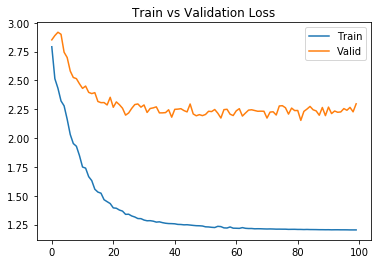

In [12]:
# loss
plt.plot(train_losses, label ='Train')
plt.plot(valid_losses, label ='Valid')
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()

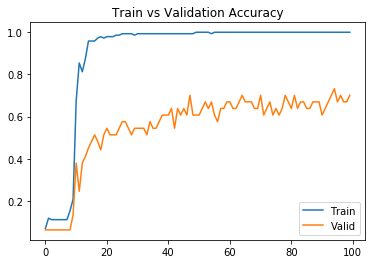

In [13]:
plt.plot(train_accuracies, label ='Train')
plt.plot(valid_accuracies, label ='Valid')
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.show() 

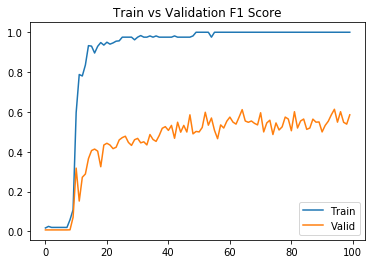

In [14]:
plt.plot(train_f1_scores, label ='Train')
plt.plot(valid_f1_scores, label ='Valid')
plt.title("Train vs Validation F1 Score")
plt.legend()
plt.show()

In [15]:
# Save the model parameters
torch.save(net.state_dict(), os.path.join(ROOT_PATH[:-4], 'models', './params_leakyRelu2_ep'+str(50)+'.pt'))

# Testing Base Model

In [43]:
net = Net().to(device)
net.load_state_dict(torch.load(os.path.join(ROOT_PATH[:-4], 'models', 'params_leakyRelu_ep50.pt')))
net.eval()

Net(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 12, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01, inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01, inplace=True)
    (11): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1))
    (12): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.01, 

In [44]:
CLASS_NAMES = {v: k for k, v in CLASS_DICT.items()} 
def get_prediction(model, device, image):
    """For prediction on single image"""
    
    image = image.unsqueeze(0).to(device)
    output = model(image)
    prediction = torch.argmax(output.data, 1).cpu().item()
    return prediction

def get_img_pred(i, test_dataset, device):
    img, target = test_dataset[i]
    pred = get_prediction(net, device, img)
    return pred, target, img
   
def show_image_predictions():
    fig = plt.figure(figsize=(20, 10))
    index = 141
    for i, _ in enumerate(range(4)):
        n = np.random.randint(len(test_dataset))
        pred, target, img = get_img_pred(n, test_dataset, device)
        plt.subplot(index+i)
        plt.imshow(np.moveaxis(img.cpu().numpy(), 0, -1), cmap='gray')
        plt.axis('off')
        plt.title(f"Input Image: {CLASS_NAMES[target]}")
        plt.axis("off")
        plt.text(25,150,f"Predicted:{CLASS_NAMES[pred]}")
    plt.show()

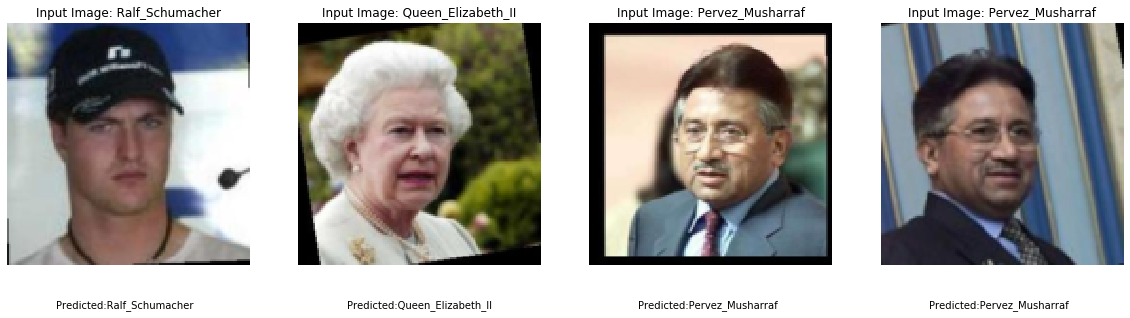

In [19]:
show_image_predictions()

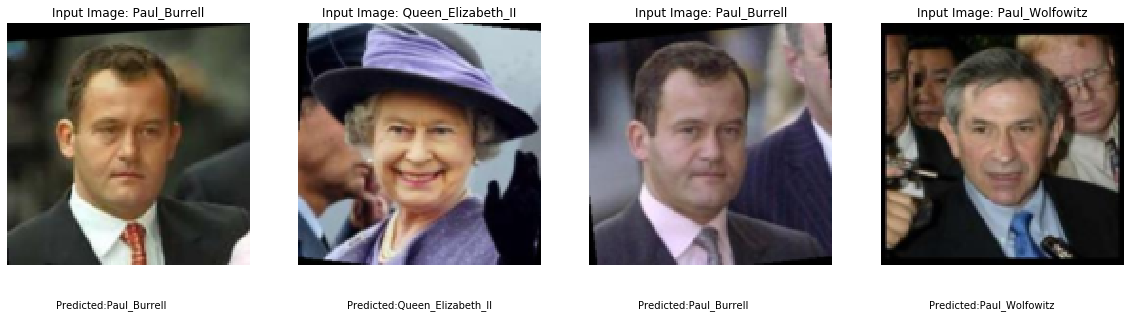

In [20]:
show_image_predictions()

# Evaluation Metris on Test Data

In [52]:
# Evaluating Metrics For Testing Data 
preds = []
targets = []
for i in range(len(test_dataset)):
    pred, target, img = get_img_pred(i, test_dataset, device)
    preds.append(pred)
    targets.append(target)
acc = metrics.accuracy_score(targets, preds)
f1_score = metrics.f1_score(targets, preds, average='macro')
print(f"Accuracy on Test Data: {acc*100:.2f}%")
print(f"F1 Score on Test Data: {f1_score*100:.2f}%")

Accuracy on Test Data: 91.89%
F1 Score on Test Data: 88.71%
